In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from kdg import kdn, kdcnn
from kdg.utils import generate_gaussian_parity, hellinger, plot_2dsim, generate_ood_samples, sample_unifrom_circle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from joblib import Parallel, delayed
from scipy.io import savemat, loadmat
from sklearn.metrics import roc_auc_score
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import activations
from tensorflow.keras import backend as bknd

### Visualize the data

<AxesSubplot: >

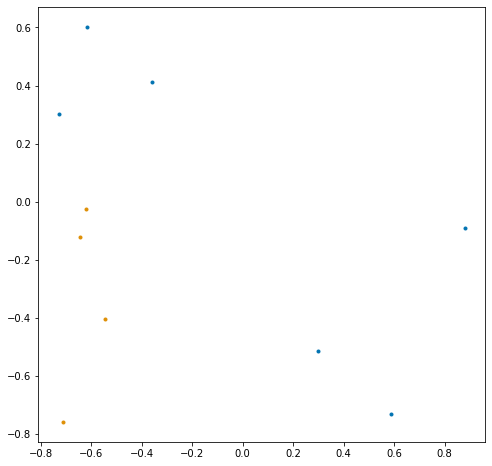

In [2]:
X, y = generate_gaussian_parity(10)
plot_2dsim(X, y)

In [3]:
compile_kwargs = {
        "loss": "binary_crossentropy",
        "optimizer": keras.optimizers.Adam(3e-4),
    }
callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10, verbose=True)
fit_kwargs = {
        "epochs": 200,
        "batch_size": 64,
        "verbose": False,
        "callbacks": [callback],
    }

In [4]:
# network architecture [10, 10, 10, 10, 2]
def getNN(input_size, num_classes):
    network_base = keras.Sequential()
    initializer = keras.initializers.random_normal(seed=0)
    network_base.add(keras.layers.Dense(2000, kernel_initializer=initializer, input_shape=(input_size,)))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(2000, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(2000, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(2000, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(units=num_classes, activation="softmax", kernel_initializer=initializer))
    network_base.compile(**compile_kwargs)
    return network_base

In [5]:
# train Vanilla NN
nn = getNN(input_size=2, num_classes=2)
history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)

2023-02-27 09:19:27.309461: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-27 09:19:27.309582: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-02-27 09:19:27.469922: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Metal device set to: Apple M1 Max


2023-02-27 09:19:27.674981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 184: early stopping


### Calculate posteriors and likelihoods using KDN

In [6]:
df = {}
model_kdn = kdn(k=.1, network=nn)
model_kdn.fit(X, y, epsilon=1e-4)

#define grids
p = np.arange(-3, 3, step=0.01)
q = np.arange(-3, 3, step=0.01)
xx, yy = np.meshgrid(p, q)

grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)
posterior_nn = model_kdn.network.predict(grid_samples)
posterior_kdn, likelihoods_kdn = model_kdn.predict_proba(grid_samples, return_likelihood=True)

posterior_nn = posterior_nn[:,0].reshape(600,600)
posterior_kdn = posterior_kdn[:,0].reshape(600,600)
class1_likelihoods = likelihoods_kdn[:,0].reshape(600,600)
class2_likelihoods = likelihoods_kdn[:,1].reshape(600,600)

df['posterior_dn'] = posterior_nn
df['posterior_kdn'] = posterior_kdn
df['likelihood_class1'] = class1_likelihoods
df['likelihood_class2'] = class2_likelihoods

/Users/jayantadey/miniforge3/envs/env/lib/python3.9/site-packages/kdg-0.0.1-py3.9.egg/kdg/kdn.py:166: RuntimeWarning: divide by zero encountered in log
/Users/jayantadey/miniforge3/envs/env/lib/python3.9/site-packages/kdg-0.0.1-py3.9.egg/kdg/kdn.py:166: RuntimeWarning: divide by zero encountered in log
/Users/jayantadey/miniforge3/envs/env/lib/python3.9/site-packages/kdg-0.0.1-py3.9.egg/kdg/kdn.py:166: RuntimeWarning: divide by zero encountered in log
/Users/jayantadey/miniforge3/envs/env/lib/python3.9/site-packages/kdg-0.0.1-py3.9.egg/kdg/kdn.py:166: RuntimeWarning: divide by zero encountered in log
/Users/jayantadey/miniforge3/envs/env/lib/python3.9/site-packages/kdg-0.0.1-py3.9.egg/kdg/kdn.py:166: RuntimeWarning: divide by zero encountered in log
/Users/jayantadey/miniforge3/envs/env/lib/python3.9/site-packages/kdg-0.0.1-py3.9.egg/kdg/kdn.py:166: RuntimeWarning: divide by zero encountered in log
/Users/jayantadey/miniforge3/envs/env/lib/python3.9/site-packages/kdg-0.0.1-py3.9.egg/kd

11250/11250 [==============================] - 27s 2ms/step


In [7]:
model_kdn.w

array([[1.        , 0.94078623, 0.56088424, 0.        , 0.        ,
        0.        , 0.        , 0.02074091, 0.06587424, 0.03366927],
       [0.94078623, 1.        , 0.526187  , 0.        , 0.        ,
        0.        , 0.        , 0.01935255, 0.07523111, 0.03014278],
       [0.56088424, 0.526187  , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.05183216, 0.01928308, 0.07411906],
       [0.        , 0.        , 0.        , 1.        , 0.49152294,
        0.63999721, 0.87012868, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.49152294, 1.        ,
        0.77782897, 0.42896942, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.63999721, 0.77782897,
        1.        , 0.55858419, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.87012868, 0.42896942,
        0.55858419, 1.        , 0.        , 0.        , 0.        ],
       [0.02074091, 0.01935255, 0.0518321

In [ ]:
# get true posterior
tp_df = pd.read_csv("../true_posterior/Gaussian_xor_pdf.csv")
proba_true = 0.5*np.ones((600, 600))
tmp = np.array([tp_df["posterior"][x] for x in range(40000)])
tmp = np.flip(tmp.reshape(200, 200), axis=1)
proba_true[200:400, 200:400] = 1 - tmp
#df["true_proba"] = proba_true

In [ ]:
fig1, ax = plt.subplots(1, 3, figsize=(30, 90))

ax0 = ax[0].imshow(
    proba_true,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[0].set_title("True Class Posteriors", fontsize=24)
ax[0].set_aspect("equal")

ax1 = ax[1].imshow(
    posterior_nn,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[1].set_title("DN Class Posteriors", fontsize=24)
ax[1].set_aspect("equal")

ax2 = ax[2].imshow(
    posterior_kdn,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    interpolation="nearest",
    aspect="auto",
)
ax[2].set_title("KDN Class Posteriors", fontsize=24)
ax[2].set_aspect("equal")
plt.show()

### Visualize class likelihoods

In [ ]:
fig1, ax = plt.subplots(1, 2, figsize=(16, 8))

class1_likelihoods /= np.max(np.max(class1_likelihoods))
class2_likelihoods /= np.max(np.max(class2_likelihoods))

ax0 = ax[0].imshow(
    class1_likelihoods,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="Reds",
    interpolation="nearest",
    aspect="auto",
)
ax[0].set_title("Class 1 Likelihoods", fontsize=24)
ax[0].set_aspect("equal")


ax1 = ax[1].imshow(
    class2_likelihoods,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="Reds",
    interpolation="nearest",
    aspect="auto",
)
ax[1].set_title("Class 2 Likelihoods", fontsize=24)
ax[1].set_aspect("equal")

### Experiment with misclassification error and hellinger distance

In [11]:
mc_reps = 10
sample_size = [50, 100, 500, 1000, 5000, 10000]
n_test = 1000

tp_df = pd.read_csv("../true_posterior/Gaussian_xor_pdf.csv")
true_posterior = tp_df['posterior']
true_posterior = np.vstack((1-true_posterior.ravel(), true_posterior.ravel())).T
        
    
def experiment_in(sample, n_test, true_posterior):
    X, y = generate_gaussian_parity(sample)
    X_test, y_test = generate_gaussian_parity(n_test)
    
    nn = getNN(input_size=2, num_classes=2)
    history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)
    model_kdn = kdn(k=.1, network=nn)
    model_kdn.fit(X, y)
    
    p = np.arange(-1, 1, step=0.01)
    q = np.arange(-1, 1, step=0.01)
    xx, yy = np.meshgrid(p, q)

    grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)

    error_kdn = 1 - np.mean(model_kdn.predict(X_test)==y_test)   
    error_dn = 1 - np.mean(np.argmax(
        model_kdn.network.predict(X_test), axis=1
    )==y_test)
    proba_kdn = model_kdn.predict_proba(grid_samples)
    proba_dn = model_kdn.network.predict(grid_samples)
    hellinger_dis_kdn = hellinger(1-true_posterior, proba_kdn)
    hellinger_dis_dn = hellinger(1-true_posterior, proba_dn)
    mmcIn_dn = np.mean(np.max(proba_dn, axis=1)) 
    mmcIn_kdn = np.mean(np.max(proba_kdn, axis=1))
    
    return error_kdn, error_dn, hellinger_dis_kdn, hellinger_dis_dn, mmcIn_kdn, mmcIn_dn

def experiment_out(in_sample, r, n_test):
    X, y = generate_gaussian_parity(in_sample)
    nn = getNN(input_size=2, num_classes=2)
    history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)
    
    model_kdn = kdn(k=.1, network=nn)
    model_kdn.fit(X, y)

    X_ood = sample_unifrom_circle(n=n_test, r=r)
    mmcOut_dn = np.mean(np.max(
        model_kdn.network.predict(X_ood), axis=1
        )
    )
    mmcOut_kdn = np.mean(np.max(model_kdn.predict_proba(X_ood), axis=1))
    
    return mmcOut_kdn, mmcOut_dn
        
    
error_kdn_med = []
error_kdn_25 = []
error_kdn_75 = []
error_dn_med = []
error_dn_25 = []
error_dn_75 = []

hellinger_kdn_med = []
hellinger_kdn_25 = []
hellinger_kdn_75 = []
hellinger_dn_med = []
hellinger_dn_25 = []
hellinger_dn_75 = []

mmcIn_kdn_med = []
mmcIn_kdn_25 = []
mmcIn_kdn_75 = []
mmcIn_dn_med = []
mmcIn_dn_25 = []
mmcIn_dn_75 = []

mmcOut_kdn_med = []
mmcOut_kdn_25 = []
mmcOut_kdn_75 = []
mmcOut_dn_med = []
mmcOut_dn_25 = []
mmcOut_dn_75 = []

#### do out-of-distribution results ####
for r in np.arange(0,10.5,.5):
    mmcOut_kdn = []
    mmcOut_dn = []
    res = Parallel(n_jobs=-1)(
            delayed(experiment_out)(
                    1000,
                    r,
                    n_test
                    ) for _ in range(mc_reps)
                )
    
    for ii in range(mc_reps):
        mmcOut_kdn.append(res[ii][0])
        mmcOut_dn.append(res[ii][1])
    
    
    mmcOut_kdn_med.append(
        np.median(mmcOut_kdn)
    )
    mmcOut_kdn_25.append(
        np.quantile(mmcOut_kdn, [0.25])[0]
    )
    mmcOut_kdn_75.append(
        np.quantile(mmcOut_kdn, [0.75])[0]
    )
    
    mmcOut_dn_med.append(
        np.median(mmcOut_dn)
    )
    mmcOut_dn_25.append(
        np.quantile(mmcOut_dn, [0.25])[0]
    )
    mmcOut_dn_75.append(
        np.quantile(mmcOut_dn, [0.75])[0]
    )
    
    
#### do in-distribution results ####
for sample in sample_size:
    res = Parallel(n_jobs=-1)(
            delayed(experiment_in)(
                    sample,
                    n_test,
                    true_posterior
                    ) for _ in range(mc_reps)
                )

    
    err_kdn = []
    err_dn = []
    hellinger_kdn = []
    hellinger_dn = []
    mmcIn_kdn = []
    mmcIn_dn = []
    for ii in range(mc_reps):
        err_kdn.append(res[ii][0])
        err_dn.append(res[ii][1])
        hellinger_kdn.append(res[ii][2])
        hellinger_dn.append(res[ii][3])
        mmcIn_kdn.append(res[ii][4])
        mmcIn_dn.append(res[ii][5])

    error_kdn_med.append(
        np.median(err_kdn)
    )
    error_kdn_25.append(
        np.quantile(err_kdn, [0.25])[0]
    )
    error_kdn_75.append(
        np.quantile(err_kdn, [0.75])[0]
    )

    error_dn_med.append(
        np.median(err_dn)
    )
    error_dn_25.append(
        np.quantile(err_dn, [0.25])[0]
    )
    error_dn_75.append(
        np.quantile(err_dn, [0.75])[0]
    )
    
    hellinger_kdn_med.append(
        np.median(hellinger_kdn)
    )
    hellinger_kdn_25.append(
        np.quantile(hellinger_kdn, [0.25])[0]
    )
    hellinger_kdn_75.append(
        np.quantile(hellinger_kdn, [0.75])[0]
    )

    hellinger_dn_med.append(
        np.median(hellinger_dn)
    )
    hellinger_dn_25.append(
        np.quantile(hellinger_dn, [0.25])[0]
    )
    hellinger_dn_75.append(
        np.quantile(hellinger_dn, [0.75])[0]
    )

    mmcIn_kdn_med.append(
        np.median(mmcIn_kdn)
    )
    mmcIn_kdn_25.append(
        np.quantile(mmcIn_kdn, [0.25])[0]
    )
    mmcIn_kdn_75.append(
        np.quantile(mmcIn_kdn, [0.75])[0]
    )

    mmcIn_dn_med.append(
        np.median(mmcIn_dn)
    )
    mmcIn_dn_25.append(
        np.quantile(mmcIn_dn, [0.25])[0]
    )
    mmcIn_dn_75.append(
        np.quantile(mmcIn_dn, [0.75])[0]
    )


df['error_kdn_med'] = error_kdn_med
df['error_kdn_25'] = error_kdn_25
df['error_kdn_75'] = error_kdn_75

df['error_dn_med'] = error_dn_med
df['error_dn_25'] = error_dn_25
df['error_dn_75'] = error_dn_75

df['hellinger_kdn_med'] = hellinger_kdn_med
df['hellinger_kdn_25'] = hellinger_kdn_25
df['hellinger_kdn_75'] = hellinger_kdn_75

df['hellinger_dn_med'] = hellinger_dn_med
df['hellinger_dn_25'] = hellinger_dn_25
df['hellinger_dn_75'] = hellinger_dn_75

df['mmcIn_kdn_med'] = mmcIn_kdn_med
df['mmcIn_kdn_25'] = mmcIn_kdn_25
df['mmcIn_kdn_75'] = mmcIn_kdn_75

df['mmcIn_dn_med'] = mmcIn_dn_med
df['mmcIn_dn_25'] = mmcIn_dn_25
df['mmcIn_dn_75'] = mmcIn_dn_75

df['mmcOut_kdn_med'] = mmcOut_kdn_med
df['mmcOut_kdn_25'] = mmcOut_kdn_25
df['mmcOut_kdn_75'] = mmcOut_kdn_75

df['mmcOut_dn_med'] = mmcOut_dn_med
df['mmcOut_dn_25'] = mmcOut_dn_25
df['mmcOut_dn_75'] = mmcOut_dn_75

INFO:tensorflow:Assets written to: ram://cf7a4d47-4124-45c1-832a-25e161a0fb48/assets
INFO:tensorflow:Assets written to: ram://06bd8cab-e224-4bba-b749-5286fce55e82/assets
INFO:tensorflow:Assets written to: ram://b9e4e1e0-765a-473f-9f2f-0094ba4e29ce/assets
INFO:tensorflow:Assets written to: ram://4dc7afd8-d2fd-4e5c-a272-21329d17e65a/assets
INFO:tensorflow:Assets written to: ram://f0058004-89c9-497d-bc5f-7ee080126985/assets
INFO:tensorflow:Assets written to: ram://dd183a54-c31a-4919-b3c4-fc6910339747/assets
INFO:tensorflow:Assets written to: ram://e39c477c-052d-4ac1-9d8b-86ceab48a2b9/assets
INFO:tensorflow:Assets written to: ram://ac63cbea-acb0-4880-9926-87f094007d1b/assets


KeyboardInterrupt: 

### Save the result

In [11]:
name = 'gxor'
filename = name + "_plot_data.mat"
savemat(filename, df)

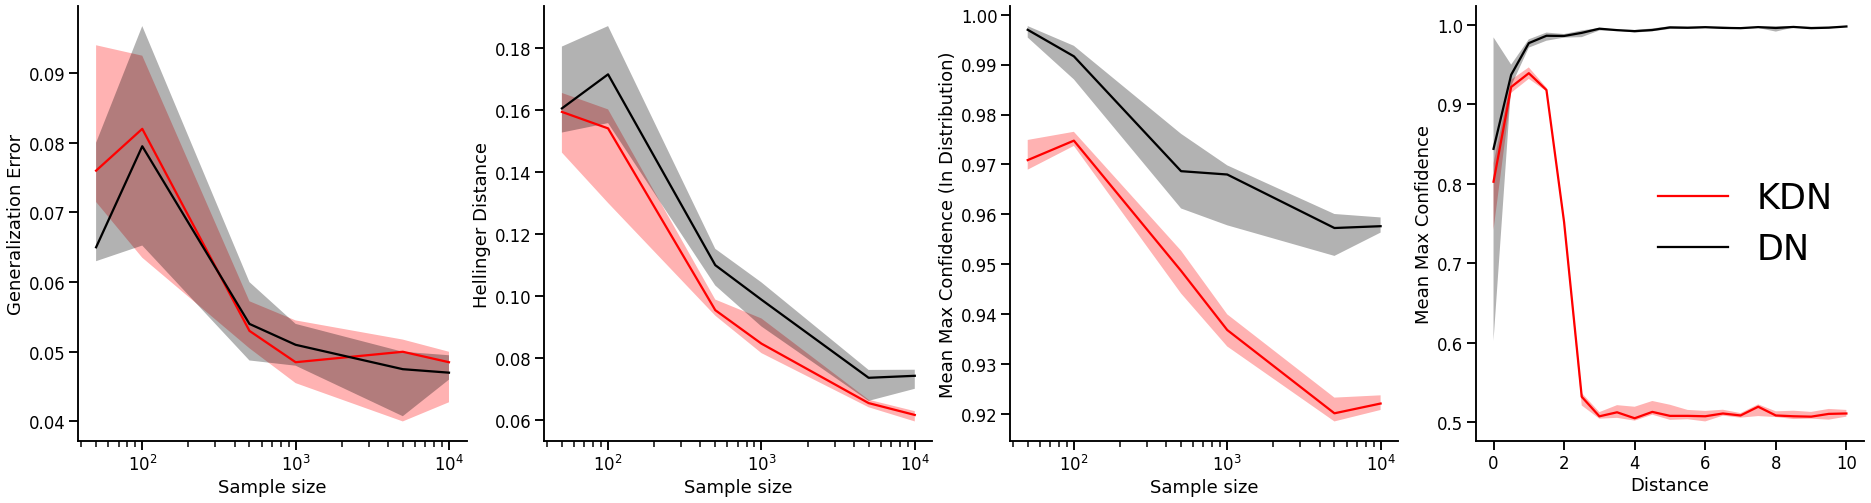

In [12]:
sample_size = [50, 100, 500, 1000, 5000, 10000]

sns.set_context('talk')
fig, ax = plt.subplots(1,4, figsize=(32,8))

ax[0].plot(sample_size, df['error_kdn_med'], c="r", label='KDN')
ax[0].plot(sample_size, df['error_dn_med'], c="k", label='DN')

ax[0].fill_between(sample_size, df['error_kdn_25'], df['error_kdn_75'], facecolor='r', alpha=.3)
ax[0].fill_between(sample_size, df['error_dn_25'], df['error_dn_75'], facecolor='k', alpha=.3)

ax[0].set_xscale('log')
ax[0].set_xlabel('Sample size')
ax[0].set_ylabel('Generalization Error')

right_side = ax[0].spines["right"]
right_side.set_visible(False)
top_side = ax[0].spines["top"]
top_side.set_visible(False)




ax[1].plot(sample_size, df['hellinger_kdn_med'], c="r", label='KDN')
ax[1].plot(sample_size, df['hellinger_dn_med'], c="k", label='DN')

ax[1].fill_between(sample_size, df['hellinger_kdn_25'], df['hellinger_kdn_75'], facecolor='r', alpha=.3)
ax[1].fill_between(sample_size, df['hellinger_dn_25'], df['hellinger_dn_75'], facecolor='k', alpha=.3)

ax[1].set_xscale('log')
ax[1].set_xlabel('Sample size')
ax[1].set_ylabel('Hellinger Distance')

right_side = ax[1].spines["right"]
right_side.set_visible(False)
top_side = ax[1].spines["top"]
top_side.set_visible(False)




ax[2].plot(sample_size, df['mmcIn_kdn_med'], c="r", label='KDN')
ax[2].plot(sample_size, df['mmcIn_dn_med'], c="k", label='DN')

ax[2].fill_between(sample_size, df['mmcIn_kdn_25'], df['mmcIn_kdn_75'], facecolor='r', alpha=.3)
ax[2].fill_between(sample_size, df['mmcIn_dn_25'], df['mmcIn_dn_75'], facecolor='k', alpha=.3)

ax[2].set_xscale('log')
ax[2].set_xlabel('Sample size')
ax[2].set_ylabel('Mean Max Confidence (In Distribution)')

right_side = ax[2].spines["right"]
right_side.set_visible(False)
top_side = ax[2].spines["top"]
top_side.set_visible(False)


r = np.arange(0,10.5,.5)
ax[3].plot(r, df['mmcOut_kdn_med'], c="r", label='KDN')
ax[3].plot(r, df['mmcOut_dn_med'], c="k", label='DN')

ax[3].fill_between(r, df['mmcOut_kdn_25'], df['mmcOut_kdn_75'], facecolor='r', alpha=.3)
ax[3].fill_between(r, df['mmcOut_dn_25'], df['mmcOut_dn_75'], facecolor='k', alpha=.3)

#ax[3].set_xscale('log')
ax[3].set_xlabel('Distance')
ax[3].set_ylabel('Mean Max Confidence')

ax[3].legend(fontsize=35, frameon=False)

right_side = ax[3].spines["right"]
right_side.set_visible(False)
top_side = ax[3].spines["top"]
top_side.set_visible(False)

### OOD detection metrics

In [15]:
def fpr_at_95_tpr(conf_t, conf_f):
    TPR = 95
    PERC = np.percentile(conf_t, 100-TPR)
    FP = np.sum(conf_f >=  PERC)
    FPR = np.sum(conf_f >=  PERC)/len(conf_f)
    return FPR, PERC

In [16]:
sample = 10000
reps = 10
n_test = 1000
true_labels = np.hstack((np.ones(n_test, ), np.zeros(n_test, )))

roc_dn = []
roc_kdn = []

fpr_dn = []
fpr_kdn = []
reps_list = []

for ii in range(reps):
    X, y = generate_gaussian_parity(sample)
    X_test, y_test = generate_gaussian_parity(n_test)
    X_ood = generate_ood_samples(n_test)

    
    nn = getNN(input_size=2, num_classes=2)
    history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)
    model_kdn = kdn(k=.1, network=nn)
    model_kdn.fit(X, y)

    dn_in_conf = np.max(model_kdn.network.predict(X_test), axis=1)
    dn_out_conf = np.max(model_kdn.network.predict(X_ood), axis=1)
    dn_conf = np.hstack((dn_in_conf, dn_out_conf))
    roc_dn.append(
        roc_auc_score(true_labels, dn_conf)
    )
    fpr_dn.append(
        fpr_at_95_tpr(dn_in_conf, dn_out_conf)
    )
    
    

    kdn_in_conf = np.max(model_kdn.predict_proba(X_test), axis=1)
    kdn_out_conf = np.max(model_kdn.predict_proba(X_ood), axis=1)
    kdn_conf = np.hstack((kdn_in_conf, kdn_out_conf))
    roc_kdn.append(
        roc_auc_score(true_labels, kdn_conf)
    )
    fpr_kdn.append(
        fpr_at_95_tpr(kdn_in_conf, kdn_out_conf)
    )

    reps_list.append(ii)

2023-02-20 22:20:46.980717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 81: early stopping
32/32 [==============================] - 0s 2ms/step


2023-02-20 22:30:14.538187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 22:30:15.320386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 40: early stopping
32/32 [==============================] - 0s 2ms/step


2023-02-20 22:39:09.687172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 22:39:10.476774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 35: early stopping
32/32 [==============================] - 0s 2ms/step


2023-02-20 22:48:04.195296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 22:48:04.985038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 84: early stopping
27/32 [========================>.....] - ETA: 0s

2023-02-20 22:57:38.071863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-02-20 22:57:38.872188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 28: early stopping
27/32 [========================>.....] - ETA: 0s

2023-02-20 23:06:36.629528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-02-20 23:06:37.435208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 30: early stopping
32/32 [==============================] - 0s 2ms/step


2023-02-20 23:15:45.459249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 23:15:46.259121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 42: early stopping
32/32 [==============================] - 0s 2ms/step


2023-02-20 23:24:57.547068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 23:24:58.356632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 51: early stopping
28/32 [=========================>....] - ETA: 0s

2023-02-20 23:34:01.751608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-02-20 23:34:02.550330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 66: early stopping
28/32 [=========================>....] - ETA: 0s

2023-02-20 23:43:26.795498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-02-20 23:43:27.598972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 83: early stopping
 1/32 [..............................] - ETA: 0s

2023-02-20 23:53:49.430368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


In [17]:
# obtain the AUROC and FPR@95 scores

# AUROC
print("KDN AUROC = {:.3f} +/- {:.3f}".format(np.mean(roc_kdn), np.std(roc_kdn)))
print("DN AUROC = {:.3f} +/- {:.3f}".format(np.mean(roc_dn), np.std(roc_dn)))

KDN AUROC = 0.969 +/- 0.005
DN AUROC = 0.223 +/- 0.027


In [18]:
# FPR@95
print("KDN FPR@95 = {:.3f} +/- {:.3f}".format(np.mean(fpr_kdn), np.std(fpr_kdn)))
print("DN FPR@95 = {:.3f} +/- {:.3f}".format(np.mean(fpr_dn), np.std(fpr_dn)))

KDN FPR@95 = 0.457 +/- 0.337
DN FPR@95 = 0.910 +/- 0.074


In [12]:
polytope_ids

array([331948751338312552385903309491561272084836295551736852410569684930431463267696262786520903771401030582904683889688626030314281055369842223714137939973175912065430213406815310360824663108201054454774402724772833845308598681176097069711100787445173269371461426089443444142279051819433845905824445113865809843774474707298370314913485914150931971080740798202120461070010989401048547798834493239898697957732281641913088020716698076601753755572818916753049820893624881702172842736564145797162693627578923239663548677773273823194261473872094670691007090815464587704846219771631206974729788691862592872977069823051482640496781783882662224668392796965298663817377929394746376283827987814220291330323985240721996704516232094873253518536168342475618539588340729529798840810110819511680391531953184677936002255392955827737420582261930250613474681210362201051362112368229096344648136223691043023329536935736499876905277668628426011729757942997862112653739661707484424702277945848248039321052252490464512776

In [10]:
model_kdn.polytope_cov

[array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.0001, 0.0001]),
 array([0.00